In [1]:
!pip3 show tensorflow-federated

Name: tensorflow-federated
Version: 0.19.0
Summary: TensorFlow Federated is an open-source federated learning framework.
Home-page: http://tensorflow.org/federated
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/gonzaq/venv/lib/python3.6/site-packages
Requires: tensorflow-model-optimization, portpicker, cachetools, semantic-version, tensorflow-privacy, numpy, tensorflow, tqdm, retrying, jax, jaxlib, grpcio, attrs, dm-tree, absl-py
Required-by: 


In [1]:
%load_ext tensorboard

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import collections
import pickle
import matplotlib.pyplot
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

# Data exploration

In [4]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [5]:
NUMBER_CLIENTS = len(emnist_train.client_ids)
print('Number of clients: {} '.format(NUMBER_CLIENTS))

Number of clients: 3383 


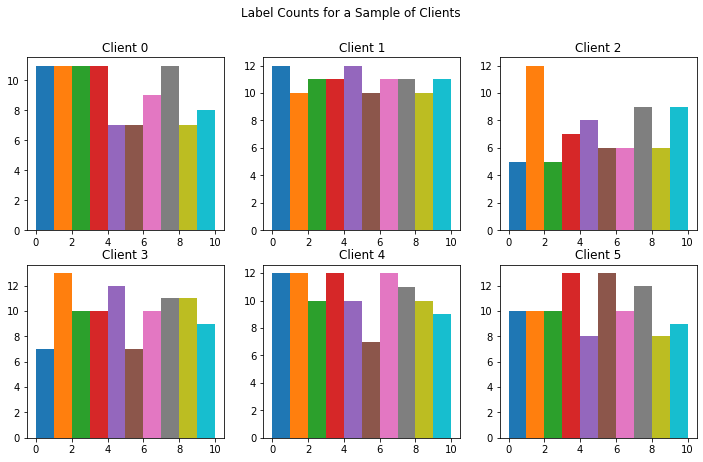

In [6]:
import matplotlib.pyplot as plt

# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
    client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
    plot_data = collections.defaultdict(list)
    for example in client_dataset:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        label = example['label'].numpy()
        plot_data[label].append(label)
    plt.subplot(2, 3, i+1)
    plt.title('Client {}'.format(i))
    for j in range(10):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

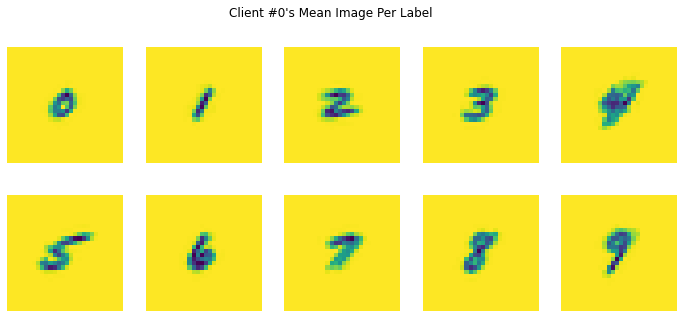

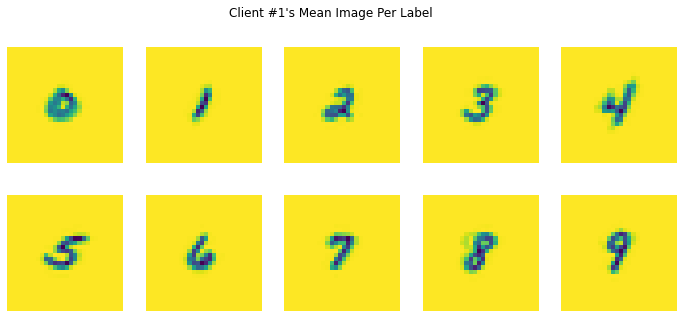

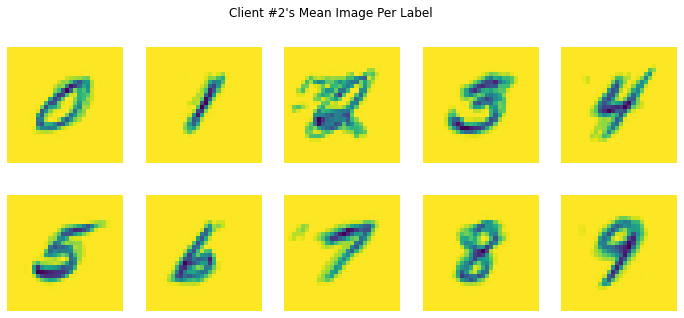

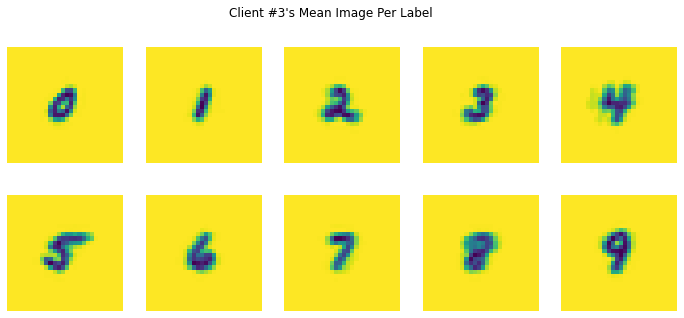

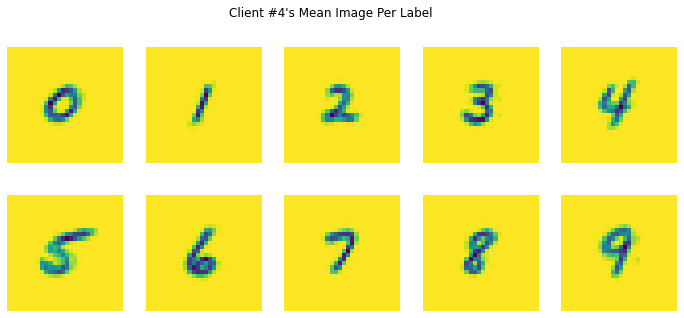

In [8]:
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(5):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i, figsize=(12, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(i))
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2, 5, j+1)
    plt.imshow(mean_img.reshape((28, 28)))
    plt.axis('off')

# Data preprocessing

In [7]:
NUM_EPOCHS = 5
BATCH_SIZE = 20
# Number of local iterations: approx 100/20*5=5*5=25
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):
    
    # 1) Flatten the 28x28 images into 784-element arrays
    # 2) Shuffle the individual examples
    # 3) Organize them into batches
    # 4) Rename the features from pixels and label to x and y for use with Keras
    # 5) Repeat over the data set to run several epochs

    def batch_format_fn(element):
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x=tf.reshape(element['pixels'], [-1, 784]),
            y=tf.reshape(element['label'], [-1, 1]))

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [8]:
def make_federated_data(client_data, client_ids):
    # Constructs a list of datasets, each dataset corresponding to a user
    return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
    ]

### For FedSGD

In [9]:
def preprocess_fed_sgd(dataset):
    
    # 1) Flatten the 28x28 images into 784-element arrays
    # 2) Shuffle the individual examples
    # 3) Organize them into batches
    # 4) Rename the features from pixels and label to x and y for use with Keras
    # 5) Only one epoch

    def batch_format_fn(element):
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x=tf.reshape(element['pixels'], [-1, 784]),
            y=tf.reshape(element['label'], [-1, 1]))

    return dataset.repeat(1).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

def make_federated_data_fed_sgd(client_data, client_ids):
    # Constructs a list of datasets, each dataset corresponding to a user
    return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
    ]

# Create model with Keras

In [10]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])
preprocessed_example_dataset = preprocess(example_dataset)

In [11]:
def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
    ])

In [12]:
def model_fn():
    # We _must_ create a new model here, and _not_ capture it from an external
    # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Implementation of the Federated Learning training

In [13]:
import random
import timeit

def add_value_to_lists_dict(_dict, key, value):
    
    if key not in _dict.keys():
        _dict[key] = [value]
    else:
        _dict[key].append(value)

def federated_training(iterative_process, evaluation, num_rounds, num_clients, is_fed_sgd=False):
    
    start_time = timeit.default_timer()
        
    metrics_dict = {}
    
    # Construct the original server state
    state = iterative_process.initialize()
    with summary_writer.as_default():
        for round_num in range(2, num_rounds):

            # Randomly pick num_clients clients
            sample_clients_train = random.sample(emnist_train.client_ids, num_clients)
            sample_clients_test = random.sample(emnist_test.client_ids, num_clients)

            # take the datasets of each client
            if is_fed_sgd:
                federated_train_data = make_federated_data_fed_sgd(emnist_train, sample_clients_train)
                federated_test_data = make_federated_data_fed_sgd(emnist_test, sample_clients_test)
            else:
                federated_train_data = make_federated_data(emnist_train, sample_clients_train)
                federated_test_data = make_federated_data(emnist_test, sample_clients_test)

            # FL iteration
            state, metrics = iterative_process.next(state, federated_train_data)

            metrics['test'] = evaluation(state.model, federated_test_data)

            print('round {:2d}, metrics={}'.format(round_num, metrics))

            for name, value in metrics['train'].items():
                tf.summary.scalar('train_'+name, value, step=round_num)
                add_value_to_lists_dict(metrics_dict, 'train_'+name, value)

            for name, value in metrics['test'].items():
                tf.summary.scalar('test_'+name, value, step=round_num)
                add_value_to_lists_dict(metrics_dict, 'test_'+name, value)
                
        stop_time = timeit.default_timer()
                
        return metrics_dict, stop_time - start_time

# Start tensorboard for visualization

In [46]:
# For visualizing the training in tensorboard, we instantiate the summary writer
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)

In [47]:
# Start tensorboard
!ls {logdir}
%tensorboard --logdir {logdir} --port=0

events.out.tfevents.1628234704.gonzaq-Satellite-C55-C.3444.1480.v2
events.out.tfevents.1628234716.gonzaq-Satellite-C55-C.3444.1488.v2
events.out.tfevents.1628244889.gonzaq-Satellite-C55-C.3444.63975.v2
events.out.tfevents.1628247119.gonzaq-Satellite-C55-C.3444.473283.v2
events.out.tfevents.1628252746.gonzaq-Satellite-C55-C.3444.1479684.v2
events.out.tfevents.1628260294.gonzaq-Satellite-C55-C.3444.1752341.v2
events.out.tfevents.1628260913.gonzaq-Satellite-C55-C.22521.1480.v2
events.out.tfevents.1628261119.gonzaq-Satellite-C55-C.22521.22643.v2


# Training with FedAvg

In [30]:
# Implementation of the federated computations, the base of this implementation of FL
# In this case, we use the FedAvg algorithm
iterative_process_fed_avg = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

evaluation = tff.learning.build_federated_evaluation(model_fn)

In [66]:
num_rounds_fed_avg = 200
num_clients_fed_avg = 30

In [ ]:
metrics_fed_avg, run_time_fed_avg = federated_training(iterative_process_fed_avg, evaluation, num_rounds=num_rounds_fed_avg, num_clients=num_clients_fed_avg)

In [ ]:
print('Algorithm run-time is: {} seconds'.format(run_time_fed_avg))

output_dict = metrics_fed_avg
output_dict['algorithm'] = 'FedAvg'
output_dict['num_rounds'] = num_rounds_fed_avg
output_dict['num_clients'] = num_clients_fed_avg
output_dict['run_time'] = run_time_fed_avg
output_dict['num_epochs'] = NUM_EPOCHS
output_dict['batch_size'] = BATCH_SIZE
output_dict['num_clients'] = NUMBER_CLIENTS

with open('results/fed_avg_data.p', 'wb') as fp:
    pickle.dump(output_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

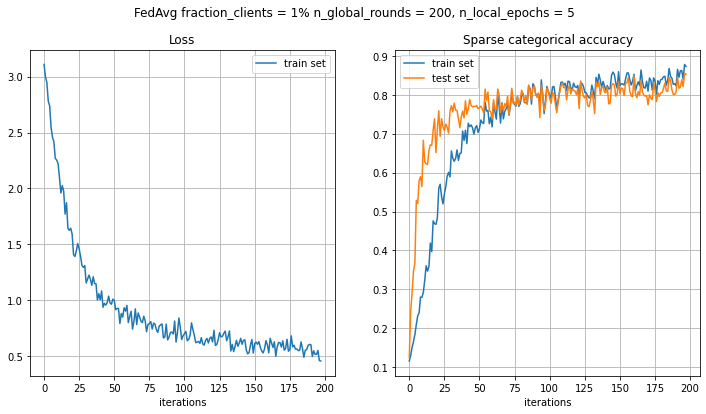

In [69]:
with open('results/fed_avg_data.p', 'rb') as fp:
    data_fed_avg = pickle.load(fp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('FedAvg fraction_clients = {}% n_global_rounds = {}, n_local_epochs = {}'.format(round(num_clients_fed_avg/NUMBER_CLIENTS*100), num_rounds_fed_avg, NUM_EPOCHS))
             
ax1.plot(data_fed_avg['train_loss'], label='train set')
ax1.set_title('Loss')
ax1.grid('on')
ax1.legend()
ax1.set_xlabel('iterations')

ax2.plot(data_fed_avg['train_sparse_categorical_accuracy'], label='train set')
ax2.plot(data_fed_avg['test_sparse_categorical_accuracy'], label='test set')
ax2.legend()
ax2.set_title('Sparse categorical accuracy')
ax2.grid('on')
ax2.set_xlabel('iterations')

plt.show()

# Training with FedSGD

In [65]:
num_rounds_fed_sgd = 500
num_clients_fed_sgd = 1

In [56]:
iterative_process_fed_sgd = tff.learning.build_federated_sgd_process(
    model_fn,
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02))

metrics_fed_sgd, run_time_sgd = federated_training(iterative_process_fed_sgd, evaluation, num_rounds=num_rounds_fed_sgd, num_clients=num_clients_fed_sgd, is_fed_sgd=True)

<class 'tensorflow_federated.python.learning.model_utils.ModelWeights'>


TypeError: Mismatched number of elements between type spec and value in `to_representation_for_type`. Type spec has 2 elements, value has 4.

In [28]:
import pickle
# save model
output_dict = metrics_fed_sgd
output_dict['algorithm'] = 'FedSGD'
output_dict['num_rounds'] = num_rounds_fed_sgd
output_dict['num_clients'] = num_clients_fed_sgd
output_dict['run_time'] = run_time_sgd
output_dict['num_epochs'] = NUM_EPOCHS
output_dict['batch_size'] = BATCH_SIZE
output_dict['num_clients'] = NUMBER_CLIENTS
with open('results/fed_sgd_500it_data.p', 'wb') as fp:
    pickle.dump(output_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
print('Algorithm run-time is: {} seconds'.format(round(run_time_sgd)))

Algorithm run-time is: 4459 seconds


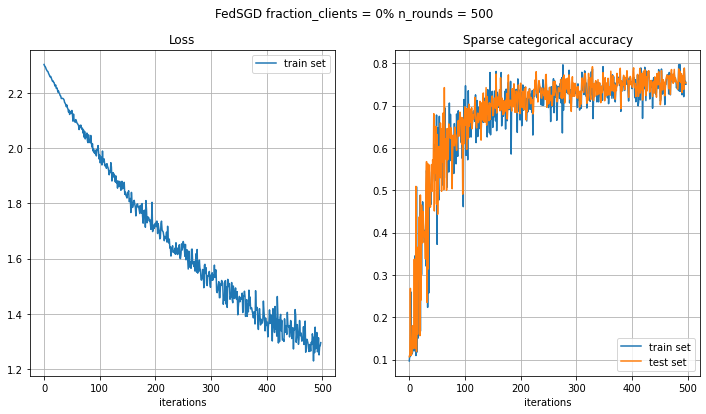

In [68]:
with open('results/fed_sgd_500it_data.p', 'rb') as fp:
    data_fed_sgd = pickle.load(fp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('FedSGD fraction_clients = {}% n_rounds = {}'.format(round(num_clients_fed_sgd/NUMBER_CLIENTS*100), num_rounds_fed_sgd))
             
ax1.plot(data_fed_sgd['train_loss'], label='train set')
ax1.set_title('Loss')
ax1.grid('on')
ax1.legend()
ax1.set_xlabel('iterations')

ax2.plot(data_fed_sgd['train_sparse_categorical_accuracy'], label='train set')
ax2.plot(data_fed_sgd['test_sparse_categorical_accuracy'], label='test set')
ax2.legend()
ax2.set_title('Sparse categorical accuracy')
ax2.grid('on')
ax2.set_xlabel('iterations')

plt.show()

# Training with FedProx 

Need to implement the algorithm, as it is not implemented natively in TensorFlow Federated

## 1 - Initialization computation

In [16]:
#@attr.s(eq=False, frozen=True, slots=True)
#class Model(object):
#    trainable_weights = attr.ib()
#    optimizer_state = attr.ib()

@tff.tf_computation
def server_init():
    model = model_fn()
    return model.trainable_variables
    #return tff.learning.ModelWeights.from_model(model)

@tff.federated_computation
def initialize_fn():
    return tff.federated_value(server_init(), tff.SERVER)

## 2 - FL iterations

### Updates in the clients' side

In [17]:
def difference_model_norm_2_square(global_model, local_model):
    """Calculates the squared l2 norm of a model difference (i.e.
    local_model - global_model)
    Args:
        global_model: the model broadcast by the server
        local_model: the current, in-training model

    Returns: the squared norm

    """
    model_difference = tf.nest.map_structure(lambda a, b: a - b,
                                           local_model,
                                           global_model)
    squared_norm = tf.square(tf.linalg.global_norm(model_difference))
    return squared_norm

@tf.function
def client_update(model, dataset, server_weights, client_optimizer, proximal_weight=0.2):
    """Performs training (using the server model weights) on the client's dataset."""
    # Initialize the client model with the current server weights.
    client_weights = model.trainable_variables
    # Assign the server weights to the client model.
    tf.nest.map_structure(lambda x, y: x.assign(y),
                        client_weights, server_weights)

    # Use the client_optimizer to update the local model.
    for batch in dataset:
        with tf.GradientTape() as tape:
            # Compute a forward pass on the batch of data
            outputs = model.forward_pass(batch)
            
            # Add the proximal term
            mu = tf.constant(proximal_weight, dtype=tf.float32)
            prox_term =(mu/2)*difference_model_norm_2_square(client_weights, server_weights)
            
            # Final loss
            fedprox_loss = outputs.loss + prox_term

        # Compute the corresponding gradient
        grads = tape.gradient(fedprox_loss, client_weights)
        grads_and_vars = zip(grads, client_weights)

        # Apply the gradient using a client optimizer.
        client_optimizer.apply_gradients(grads_and_vars)

    return client_weights

### Updates on the server's side

In [18]:
@tf.function
def server_update(model, mean_client_weights):
    """Updates the server model weights as the average of the client model weights."""
    model_weights = model.trainable_variables
    # Assign the mean client weights to the server model.
    tf.nest.map_structure(lambda x, y: x.assign(y),
                        model_weights, mean_client_weights)
    return model_weights

### Create tff.tf_computation for the clients' and server's updates

In [72]:
PROXIMAL_WEIGHT = 1.0
whimsy_model = model_fn()
tf_dataset_type = tff.SequenceType(whimsy_model.input_spec)

model_weights_type = server_init.type_signature.result
#trainable_weights_type = model_weights_type.trainable

@tff.tf_computation(tf_dataset_type, model_weights_type)
def client_update_fn(tf_dataset, server_weights):
    model = model_fn()
    client_optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
    return client_update(model, tf_dataset, server_weights, client_optimizer, proximal_weight=PROXIMAL_WEIGHT)

@tff.tf_computation(model_weights_type)
def server_update_fn(mean_client_weights):
    model = model_fn()
    return server_update(model, mean_client_weights)

In [73]:
federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)

In [74]:
str(federated_server_type)

'<float32[784,10],float32[10]>@SERVER'

In [75]:
@tff.federated_computation(federated_server_type, federated_dataset_type)
def next_fn(server_weights, federated_dataset):
    # Broadcast the server weights to the clients.
    server_weights_at_client = tff.federated_broadcast(server_weights)

    # Each client computes their updated weights.
    client_weights = tff.federated_map(
      client_update_fn, (federated_dataset, server_weights_at_client))

    # The server averages these updates.
    mean_client_weights = tff.federated_mean(client_weights)

    # The server updates its model.
    server_weights = tff.federated_map(server_update_fn, mean_client_weights)
    print(type(server_weights))
    

    return server_weights

<class 'tensorflow_federated.python.core.impl.federated_context.value_impl.Value'>


In [76]:
print(str(initialize_fn.type_signature))
print(str(next_fn.type_signature))

( -> <float32[784,10],float32[10]>@SERVER)
(<server_weights=<float32[784,10],float32[10]>@SERVER,federated_dataset={<x=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <float32[784,10],float32[10]>@SERVER)


In [77]:
iterative_process_fed_prox = tff.templates.IterativeProcess(
    initialize_fn=initialize_fn,
    next_fn=next_fn
)

We have a look at the signatures

In [78]:
print(str(iterative_process_fed_prox.initialize.type_signature))
print(str(iterative_process_fed_prox.next.type_signature))
print(str(evaluation.type_signature))

( -> <float32[784,10],float32[10]>@SERVER)
(<server_weights=<float32[784,10],float32[10]>@SERVER,federated_dataset={<x=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <float32[784,10],float32[10]>@SERVER)
(<server_model_weights=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>@SERVER,federated_dataset={<x=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <sparse_categorical_accuracy=float32,loss=float32>@SERVER)


### Train with FedProx

In [79]:
def federated_training_custom_model(iterative_process, evaluation, num_rounds, num_clients):
    
    start_time = timeit.default_timer()
        
    metrics_dict = {}
    
    # Construct the original server state
    state = iterative_process.initialize()
    with summary_writer.as_default():
        for round_num in range(2, num_rounds):
            
            metrics = {}

            # Randomly pick num_clients clients
            sample_clients_train = random.sample(emnist_train.client_ids, num_clients)
            sample_clients_test = random.sample(emnist_test.client_ids, num_clients)

            # take the datasets of each client
            federated_train_data = make_federated_data(emnist_train, sample_clients_train)
            federated_test_data = make_federated_data(emnist_test, sample_clients_test)

            # FL iteration
            state = iterative_process.next(state, federated_train_data)

            # evaluation
            model = create_tff_model_with_weights(state)

            metrics['train'] = evaluation(model, federated_train_data)
            metrics['test'] = evaluation(model, federated_test_data)

            print('round {:2d}, metrics={}'.format(round_num, metrics))

            for name, value in metrics['train'].items():
                tf.summary.scalar('train_'+name, value, step=round_num)
                add_value_to_lists_dict(metrics_dict, 'train_'+name, value)

            for name, value in metrics['test'].items():
                tf.summary.scalar('test_'+name, value, step=round_num)
                add_value_to_lists_dict(metrics_dict, 'test_'+name, value)
                
        stop_time = timeit.default_timer()
                
        return metrics_dict, stop_time - start_time

In [80]:
str(evaluation.type_signature)

'(<server_model_weights=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>@SERVER,federated_dataset={<x=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <sparse_categorical_accuracy=float32,loss=float32>@SERVER)'

In [81]:
def create_tff_model_with_weights(server_state):
    
    keras_model = create_keras_model()
    keras_model.set_weights(server_state)    
    model = tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    return tff.learning.ModelWeights.from_model(model)

In [82]:
num_rounds_fed_prox = 200
num_clients_fed_prox = 30

metrics_fed_prox, run_time_prox = federated_training_custom_model(iterative_process_fed_prox, evaluation, num_rounds=num_rounds_fed_prox, num_clients=num_clients_fed_prox)

round  2, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.09639367), ('loss', 2.2876825)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.08290155), ('loss', 2.3131459)])}
round  3, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.13473466), ('loss', 2.18828)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.12857144), ('loss', 2.222719)])}
round  4, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.36204663), ('loss', 2.1395125)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.37254903), ('loss', 2.1252973)])}
round  5, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.2759918), ('loss', 2.0716503)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.24860336), ('loss', 2.117598)])}
round  6, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.40776038), ('loss', 2.0004559)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.41223404), ('loss', 1.990414)])}
round  7, metric

round 44, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.75269496), ('loss', 1.0065275)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.7101064), ('loss', 1.0788758)])}
round 45, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.78131485), ('loss', 0.93804854)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.7733333), ('loss', 0.9687423)])}
round 46, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.7227559), ('loss', 1.0676595)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.77628034), ('loss', 0.9461557)])}
round 47, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.72407234), ('loss', 1.0178354)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.7234637), ('loss', 1.0292991)])}
round 48, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.6882859), ('loss', 1.1074684)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.75766015), ('loss', 0.9248263)])}
round 49, metr

round 86, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.80129737), ('loss', 0.74210626)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.74246573), ('loss', 0.8563688)])}
round 87, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.76963717), ('loss', 0.823202)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.79733336), ('loss', 0.7767024)])}
round 88, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.79564214), ('loss', 0.8022225)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.73315364), ('loss', 0.8958873)])}
round 89, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.80225444), ('loss', 0.72082233)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.77105266), ('loss', 0.7953526)])}
round 90, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.7860404), ('loss', 0.78211695)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.75), ('loss', 0.8299547)])}
round 91, metri

round 128, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.82713205), ('loss', 0.63937783)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.827027), ('loss', 0.64485675)])}
round 129, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.82111925), ('loss', 0.63353014)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.7878788), ('loss', 0.7034023)])}
round 130, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.8300548), ('loss', 0.630346)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.80273974), ('loss', 0.74750364)])}
round 131, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.7578504), ('loss', 0.8073647)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.7983651), ('loss', 0.7199762)])}
round 132, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.79304844), ('loss', 0.69331944)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.7912088), ('loss', 0.6844915)])}
round 13

round 170, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.8029364), ('loss', 0.67727387)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.8038147), ('loss', 0.65848625)])}
round 171, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.7931152), ('loss', 0.7112463)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.82417583), ('loss', 0.62855464)])}
round 172, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.7802391), ('loss', 0.7377787)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.8251366), ('loss', 0.57861763)])}
round 173, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.80141366), ('loss', 0.6629251)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.795756), ('loss', 0.6825331)])}
round 174, metrics={'train': OrderedDict([('sparse_categorical_accuracy', 0.81427145), ('loss', 0.612418)]), 'test': OrderedDict([('sparse_categorical_accuracy', 0.8438356), ('loss', 0.5303768)])}
round 175,

In [84]:
import pickle
# save model
output_dict = metrics_fed_prox
output_dict['algorithm'] = 'FedProx'
output_dict['proximal_weight'] = PROXIMAL_WEIGHT
output_dict['num_rounds'] = num_rounds_fed_prox
output_dict['num_clients'] = num_clients_fed_prox
output_dict['run_time'] = run_time_prox
output_dict['num_epochs'] = NUM_EPOCHS
output_dict['batch_size'] = BATCH_SIZE
output_dict['num_clients'] = NUMBER_CLIENTS
with open('results/fed_prox_200it_mu1_data.p', 'wb') as fp:
    pickle.dump(output_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
print('Algorithm run-time is: {} seconds'.format(round(num_rounds_fed_prox)))

Algorithm run-time is: 200 seconds


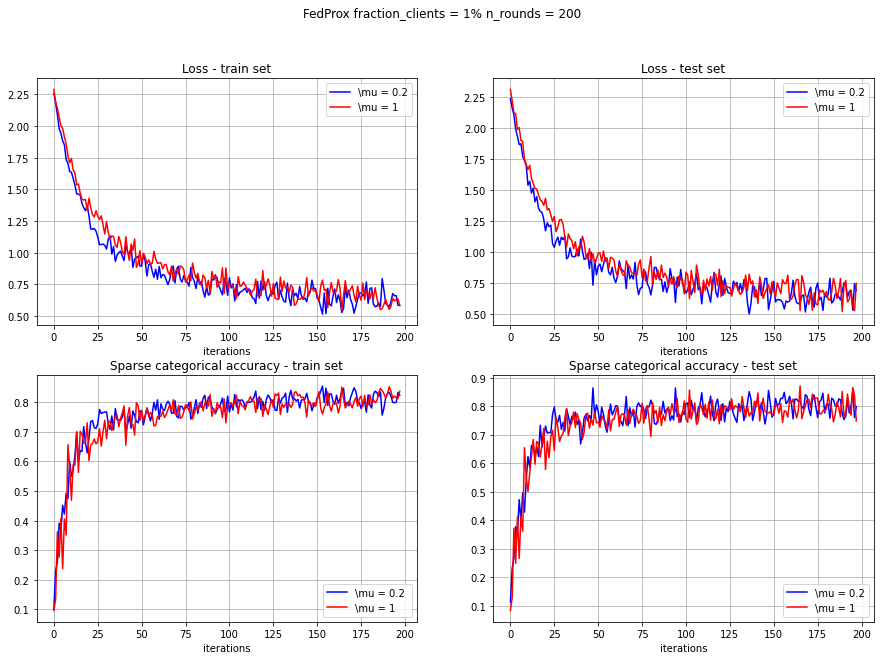

In [104]:
with open('results/fed_prox_200it_mu02_data.p', 'rb') as fp:
    data_fed_prox_mu02 = pickle.load(fp)
with open('results/fed_prox_200it_mu1_data.p', 'rb') as fp:
    data_fed_prox_mu1 = pickle.load(fp)

fig, ((ax1, ax2,),(ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('FedProx fraction_clients = {}% n_rounds = {}'.format(round(num_clients_fed_prox/NUMBER_CLIENTS*100), num_rounds_fed_prox))
             
ax1.plot(data_fed_prox_mu02['train_loss'], '-b', label='\mu = 0.2')
ax1.plot(data_fed_prox_mu1['train_loss'], '-r', label='\mu = 1')
ax1.set_title('Loss - train set')
ax1.grid('on')
ax1.legend()
ax1.set_xlabel('iterations')

ax2.plot(data_fed_prox_mu02['test_loss'], '-b', label='\mu = 0.2')
ax2.plot(data_fed_prox_mu1['test_loss'], '-r', label='\mu = 1')
ax2.set_title('Loss - test set')
ax2.grid('on')
ax2.legend()
ax2.set_xlabel('iterations')

ax3.plot(data_fed_prox_mu02['train_sparse_categorical_accuracy'], '-b', label='\mu = 0.2 ')
ax3.plot(data_fed_prox_mu1['train_sparse_categorical_accuracy'], '-r', label='\mu = 1')
ax3.legend()
ax3.set_title('Sparse categorical accuracy - train set')
ax3.grid('on')
ax3.set_xlabel('iterations')

ax4.plot(data_fed_prox_mu02['test_sparse_categorical_accuracy'], '-b', label='\mu = 0.2')
ax4.plot(data_fed_prox_mu1['test_sparse_categorical_accuracy'], '-r', label='\mu = 1')      
ax4.legend()
ax4.set_title('Sparse categorical accuracy - test set')
ax4.grid('on')
ax4.set_xlabel('iterations')

plt.show()

# Comparisons of the algorithms

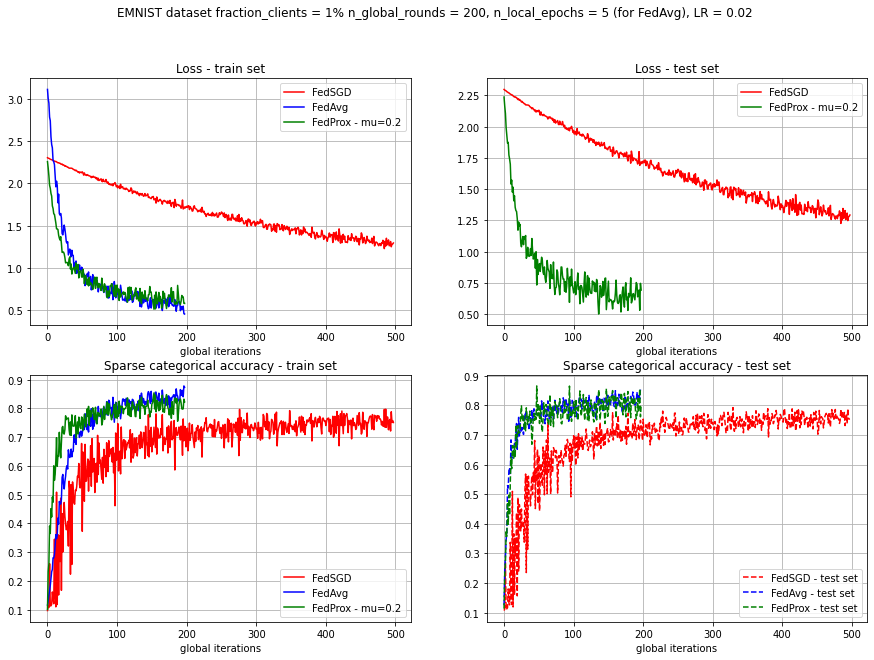

In [107]:
fig, ((ax1, ax2,),(ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('EMNIST dataset fraction_clients = {}% n_global_rounds = {}, n_local_epochs = {} (for FedAvg), LR = {}'
             .format(round(num_clients_fed_avg/NUMBER_CLIENTS*100), num_rounds_fed_avg, NUM_EPOCHS, 0.02))
             
ax1.plot(data_fed_sgd['train_loss'], '-r', label='FedSGD')
ax1.plot(data_fed_avg['train_loss'], '-b', label='FedAvg')
ax1.plot(data_fed_prox_mu02['train_loss'], '-g', label='FedProx - mu=0.2')
ax1.set_title('Loss - train set')
ax1.grid('on')
ax1.legend()
ax1.set_xlabel('global iterations')

ax2.plot(data_fed_sgd['test_loss'], '-r', label='FedSGD')
#ax2.plot(data_fed_avg['test_loss'], '-b', label='FedAvg')
ax2.plot(data_fed_prox_mu02['test_loss'], '-g', label='FedProx - mu=0.2')
ax2.set_title('Loss - test set')
ax2.grid('on')
ax2.legend()
ax2.set_xlabel('global iterations')

ax3.plot(data_fed_sgd['train_sparse_categorical_accuracy'], '-r', label='FedSGD')
ax3.plot(data_fed_avg['train_sparse_categorical_accuracy'], '-b', label='FedAvg')
ax3.plot(data_fed_prox_mu02['train_sparse_categorical_accuracy'], '-g', label='FedProx - mu=0.2')
ax3.legend()
ax3.set_title('Sparse categorical accuracy - train set')
ax3.grid('on')
ax3.set_xlabel('global iterations')

ax4.plot(data_fed_sgd['test_sparse_categorical_accuracy'], '--r', label='FedSGD - test set')
ax4.plot(data_fed_avg['test_sparse_categorical_accuracy'], '--b', label='FedAvg - test set')
ax4.plot(data_fed_prox_mu02['test_sparse_categorical_accuracy'], '--g', label='FedProx - test set')
ax4.legend()
ax4.set_title('Sparse categorical accuracy - test set')
ax4.grid('on')
ax4.set_xlabel('global iterations')

plt.show()